In [4]:
# === Upload dan Import ===
from google.colab import files
uploaded = files.upload()

Saving jabodetabek_house_price.csv to jabodetabek_house_price.csv


In [5]:
# === IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

In [6]:
# === LOAD DATASET ===
data = pd.read_csv('jabodetabek_house_price.csv')

In [7]:
print("Jumlah baris dan kolom:", data.shape)

Jumlah baris dan kolom: (3553, 27)


In [4]:
# --- EDA: Gambaran Awal Dataset ---
print("Jumlah baris & kolom:", data.shape)
print("\nTipe Data:")
print(data.dtypes)

print("\nJumlah Missing Values per Kolom:")
print(data.isnull().sum())

print("\nStatistik Deskriptif:")
print(data.describe().T)

Jumlah baris & kolom: (3553, 27)

Tipe Data:
url                      object
price_in_rp             float64
title                    object
address                  object
district                 object
city                     object
lat                     float64
long                    float64
facilities               object
property_type            object
ads_id                   object
bedrooms                float64
bathrooms               float64
land_size_m2            float64
building_size_m2        float64
carports                float64
certificate              object
electricity              object
maid_bedrooms           float64
maid_bathrooms          float64
floors                  float64
building_age            float64
year_built              float64
property_condition       object
building_orientation     object
garages                 float64
furnishing               object
dtype: object

Jumlah Missing Values per Kolom:
url                        0
price_in_rp   

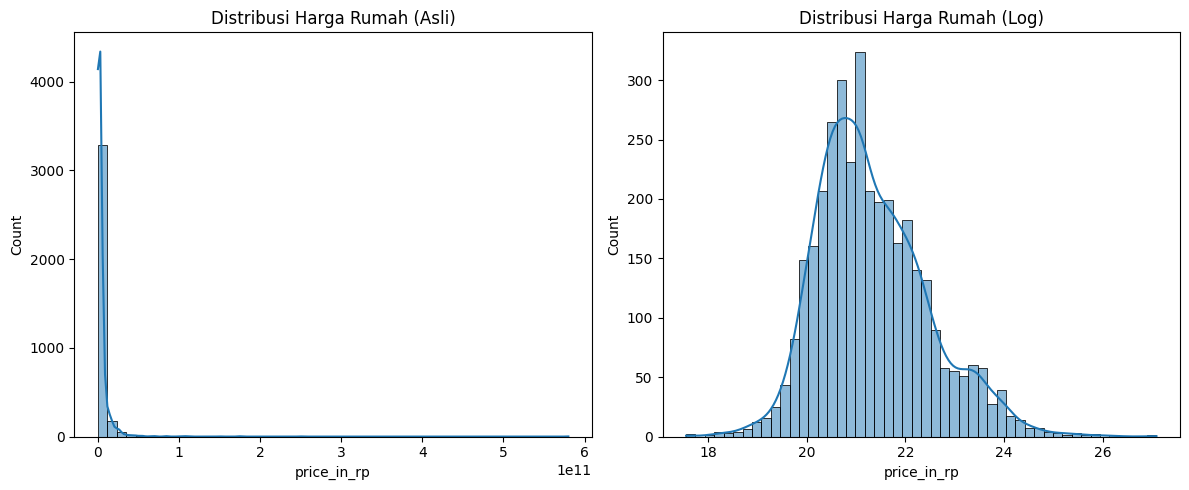

In [5]:
# --- Distribusi Harga Rumah (Asli dan Log) ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['price_in_rp'], bins=50, kde=True)
plt.title('Distribusi Harga Rumah (Asli)')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(data['price_in_rp']), bins=50, kde=True)
plt.title('Distribusi Harga Rumah (Log)')

plt.tight_layout()
plt.show()

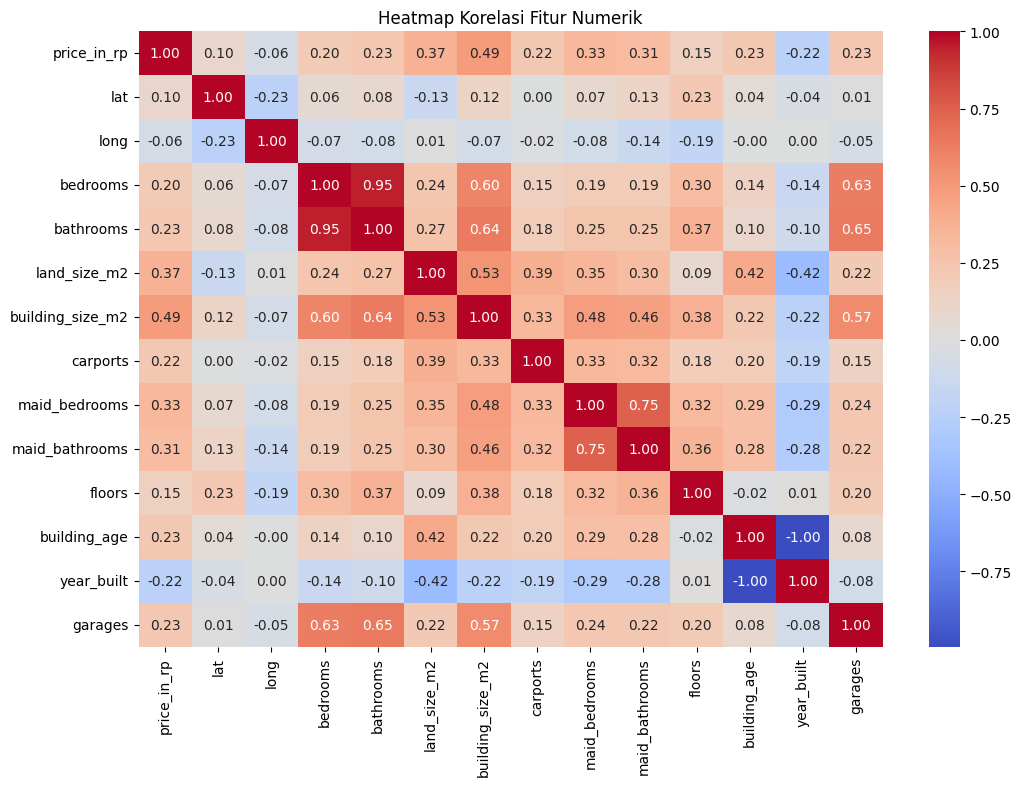

In [6]:
# --- Korelasi Antar Fitur Numerik ---
plt.figure(figsize=(12, 8))
corr = data.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

In [7]:
# === FITUR NUMERIK TURUNAN ===
data['building_density'] = data['building_size_m2'] / (data['land_size_m2'] + 1)
data['room_ratio'] = (data['bedrooms'] + data['bathrooms']) / (data['floors'] + 1)
data['bed_bath_ratio'] = data['bedrooms'] / (data['bathrooms'] + 1)

In [8]:
# === HAPUS OUTLIER HARGA (1% atas & bawah) ===
data = data[
    (data['price_in_rp'] > data['price_in_rp'].quantile(0.01)) &
    (data['price_in_rp'] < data['price_in_rp'].quantile(0.99))
]

In [9]:
# === DEFINISI FITUR ===
fitur_numerik = [
    'lat', 'long', 'bedrooms', 'bathrooms', 'land_size_m2',
    'building_size_m2', 'carports', 'maid_bedrooms', 'maid_bathrooms',
    'floors', 'building_age', 'year_built', 'garages',
    'building_density', 'room_ratio', 'bed_bath_ratio'
]

fitur_kategorikal = [
    'district', 'city', 'property_type', 'certificate',
    'furnishing', 'property_condition', 'building_orientation'
]

In [10]:
# === TANGANI MISSING VALUE ===
X_num = data[fitur_numerik].fillna(0)
X_cat = data[fitur_kategorikal].fillna("Tidak Diketahui")
X = pd.concat([X_num, X_cat], axis=1)
y = data['price_in_rp']
y_log = np.log1p(y)

In [11]:
# === SPLIT DATA ===
X_train, X_test, y_train_log, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [12]:
# === PREPROCESSING ===
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), fitur_numerik),
    ('cat', OneHotEncoder(handle_unknown='ignore'), fitur_kategorikal)
])

In [13]:
# ==========================
# === Random Forest Model ===
# ==========================
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'model__n_estimators': [200],
    'model__max_depth': [30, None],
    'model__min_samples_split': [2, 5],
    'model__max_features': ['sqrt', None]
}

grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train_log)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['lat',
                                                                          'long',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'land_size_m2',
                                                                          'building_size_m2',
                                                                          'carports',
                                                                          'maid_bedrooms',
                                                                          'maid_bathrooms',
                                                                          'floors',
                                                                          'building_age',
                                                                          'year_built',
                                                                          'garages',
                                                                          'building_density',
                                                                          'room_ratio',
                                                                          'bed_bath_ratio']),
                                                                        ('cat',
                                                                         OneHotEncoder(...ore'),
                                                                         ['district',
                                                                          'city',
                                                                          'property_type',
                                                                          'certificate',
                                                                          'furnishing',
                                                                          'property_condition',
                                                                          'building_orientation'])])),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [30, None],
                         'model__max_features': ['sqrt', None],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [200]},
             scoring='r2', verbose=1)

In [14]:
# === EVALUASI RANDOM FOREST ===
y_pred_rf = np.expm1(grid_rf.predict(X_test))
y_true = np.expm1(y_test)

print("\n[RANDOM FOREST]")
print("✅ Best Params:", grid_rf.best_params_)
print("📊 MAE :", round(mean_absolute_error(y_true, y_pred_rf)))
print("📊 RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred_rf))))
print("📈 R²  :", round(r2_score(y_true, y_pred_rf), 4))


[RANDOM FOREST]
✅ Best Params: {'model__max_depth': None, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
📊 MAE : 654319962
📊 RMSE: 1860495807
📈 R²  : 0.8432


In [15]:
# ==========================
# === XGBoost Model ===
# ==========================
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

param_grid_xgb = {
    'model__n_estimators': [200],
    'model__max_depth': [6, 10],
    'model__learning_rate': [0.1, 0.05]
}

grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_xgb.fit(X_train, y_train_log)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['lat',
                                                                          'long',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'land_size_m2',
                                                                          'building_size_m2',
                                                                          'carports',
                                                                          'maid_bedrooms',
                                                                          'maid_bathrooms',
                                                                          'floors',
                                                                          'building_age',
                                                                          'year_built',
                                                                          'garages',
                                                                          'building_density',
                                                                          'room_ratio',
                                                                          'bed_bath_ratio']),
                                                                        ('cat',
                                                                         OneHotEncoder(...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.05],
                         'model__max_depth': [6, 10],
                         'model__n_estimators': [200]},
             scoring='r2', verbose=1)

In [16]:
# === EVALUASI XGBOOST ===
y_pred_xgb = np.expm1(grid_xgb.predict(X_test))

print("\n[XGBOOST]")
print("📌 Best Params:", grid_xgb.best_params_)
print("📊 MAE :", round(mean_absolute_error(y_true, y_pred_xgb)))
print("📊 RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred_xgb))))
print("📈 R²  :", round(r2_score(y_true, y_pred_xgb), 4))


[XGBOOST]
📌 Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}
📊 MAE : 637125215
📊 RMSE: 1716557060
📈 R²  : 0.8665


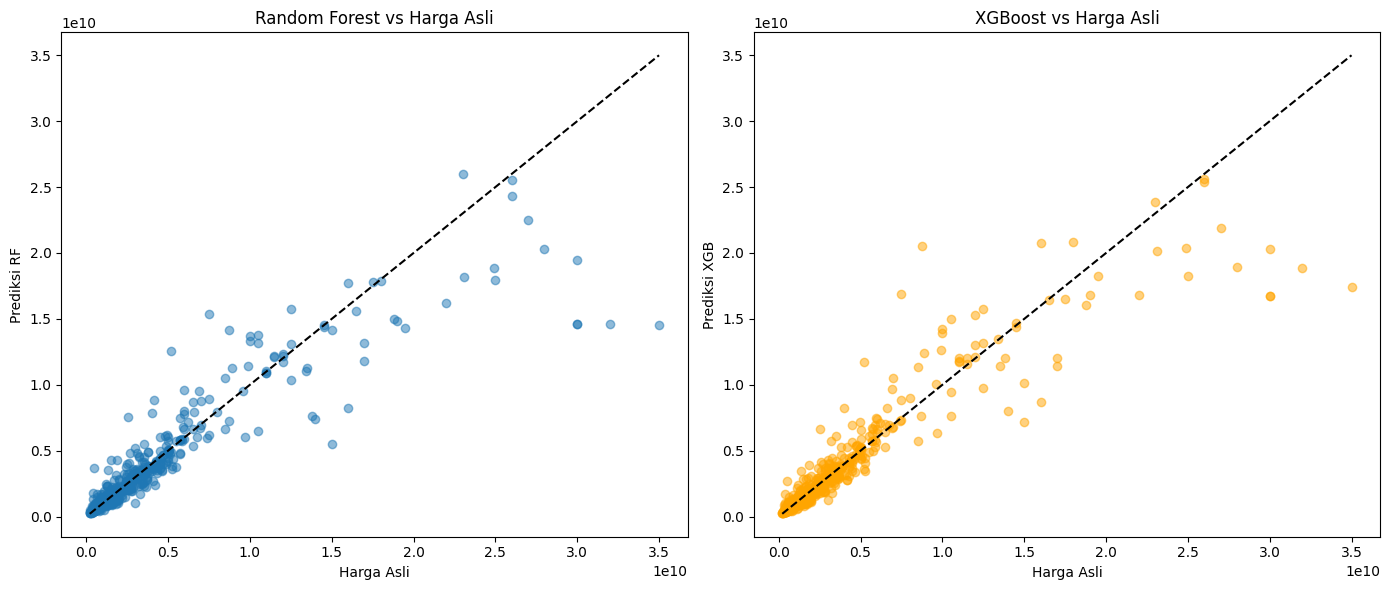

In [17]:
# === Visualisasi Perbandingan ===
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred_rf, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
plt.title("Random Forest vs Harga Asli")
plt.xlabel("Harga Asli")
plt.ylabel("Prediksi RF")

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_xgb, alpha=0.5, color='orange')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
plt.title("XGBoost vs Harga Asli")
plt.xlabel("Harga Asli")
plt.ylabel("Prediksi XGB")

plt.tight_layout()
plt.show()


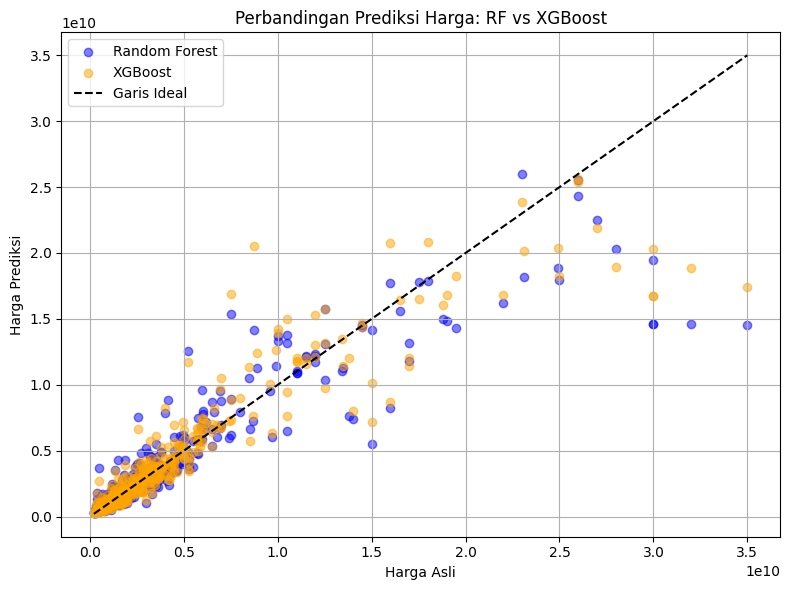

In [18]:
# === Visualisasi Gabungan RF dan XGB ===
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_rf, alpha=0.5, label='Random Forest', color='blue')
plt.scatter(y_true, y_pred_xgb, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label='Garis Ideal')
plt.title("Perbandingan Prediksi Harga: RF vs XGBoost")
plt.xlabel("Harga Asli")
plt.ylabel("Harga Prediksi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
